## マルチエージェントを活用したシステム要件定義作成処理

In [20]:
import os
from dotenv import load_dotenv

load_dotenv()
openai_key = os.environ["OPEN_AI_KEY"]

In [21]:
# LLMオブジェクトの作成
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(api_key=openai_key, model="gpt-4o-mini")

In [22]:
# 処理全体で使用するstate設定
import operator
from typing import Annotated
from pydantic import BaseModel, Field

class State(BaseModel):
    query: str = Field(..., description="ユーザからの質問")
    messages: Annotated[list[str], operator.add] = Field(default=[], description="回答履歴")
    current_judge: bool = Field(default=False, description="品質チェックの結果")
    judgement_reason: str = Field(default="", description="品質チェックの判定理由")

### 各エージェントの作成

In [23]:
# システム開発者のツール
from typing import Literal
from langgraph.types import Command
from langchain_core.prompts import ChatPromptTemplate

class SystemDeveloperAnswerFormat(BaseModel):
    answer: str = Field(..., description="回答内容")

def system_developer_node(state: State) -> Command[Literal["supervisor"]]:
    prompt = ChatPromptTemplate.from_template(
        """
        あなたは経験豊富なシステム開発エキスパートです。
        あなたの役割は、システム開発プロジェクトにおいて、技術的な要件を明確にし、プロジェクトの成功に向けた具体的なステップを提案することです。
        
        以下の情報を考慮して、システム開発の観点から必要な要件と確認すべきポイントをステップバイステップで洗い出してください：

        1. プロジェクトの目的と範囲
        2. 主要な技術的課題とその解決策
        3. 必要なリソースとスキルセット
        4. 開発プロセスの各フェーズでの重要なマイルストーン
        5. リスク管理とその緩和策
        6. 成功のための主要な成功指標（KPI）

        対象のシステム開発内容：{query}
        """
    )

    chain = prompt | llm.with_structured_output(SystemDeveloperAnswerFormat)
    response = chain.invoke({"query": state.query})

    return Command(
            update={"messages": ["system_developer", response.answer]},
            goto="supervisor",
    )

In [24]:
# システム運用者のツール
from pydantic import BaseModel, Field
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate

class SystemOperatorAnswerFormat(BaseModel):
    answer: str = Field(..., description="回答内容")

def system_operator_node(state: State) -> Command[Literal["supervisor"]]:
    prompt = ChatPromptTemplate.from_template(
    """
    あなたはシステム運用エキスパートとして、20年以上の経験を持つベテランです。
    新規システム開発案件に対して、運用フェーズでの課題を事前に特定し、適切な要件を提示することが求められています。

    以下の観点から、システム開発内容を分析し、具体的な要件と確認項目を挙げてください：

    1. 可用性要件
    - システムの稼働時間要件
    - バックアップ/リストア要件
    - 障害時の復旧時間目標（RTO）
    - 災害対策（DR）要件

    2. 運用監視要件
    - 監視すべき項目とそのしきい値
    - アラート通知の基準と方法
    - ログ収集/保管要件
    - パフォーマンスモニタリング要件

    3. セキュリティ運用要件
    - アクセス制御要件
    - 脆弱性対応プロセス
    - セキュリティパッチ適用方針
    - インシデント対応手順

    4. 保守運用要件
    - 定期メンテナンス要件
    - バージョンアップ方針
    - 構成管理要件
    - ドキュメント管理要件

    5. サポート体制要件
    - 運用体制（シフト要件）
    - ヘルプデスク対応範囲
    - エスカレーションフロー
    - SLA要件

    対象のシステム開発内容：{query}

    各観点について、具体的な要件と確認項目を箇条書きで示してください。
    """
    )

    chain = prompt | llm.with_structured_output(SystemOperatorAnswerFormat)
    response = chain.invoke({"query": state.query})

    return Command(
            update={"messages": ["system_operator", response.answer]},
            goto="supervisor",
    )

In [25]:
# システム設計者のツール
from pydantic import BaseModel, Field
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate

class SystemArchitectAnswerFormat(BaseModel):
    answer: str = Field(..., description="回答内容")

def system_architect_node(state: State) -> Command[Literal["supervisor"]]:
    """システム設計者が管理者からの質問に対して回答するためのツール"""
    prompt = ChatPromptTemplate.from_template(
    """
    あなたは経験豊富なシステムアーキテクトとして、以下の観点からシステム設計の提案を行ってください。
    
    1. アーキテクチャ設計
    - ★システム全体のアーキテクチャパターン（マイクロサービス、モノリス等）
    - コンポーネント間の依存関係
    - スケーラビリティ要件
    - 外部システムとの連携方式
    
    2. 技術スタック
    - ★推奨される開発言語とフレームワーク
    - データベース選定
    - ミドルウェア要件
    - インフラストラクチャ（クラウド/オンプレミス）
    
    3. 性能要件
    - ★想定される負荷と対応策
    - レスポンスタイム要件
    - スループット要件
    - リソース使用量の見積もり
    
    4. セキュリティ設計
    - ★認証・認可方式
    - データ暗号化要件
    - セキュアコーディング基準
    - 脆弱性対策
    
    5. データ設計
    - ★データモデル概要
    - マスターデータ管理
    - トランザクション管理
    - データバックアップ戦略
    
    6. 品質要件
    - テスト戦略
    - コード品質基準
    - パフォーマンス基準
    - 信頼性要件

    対象のシステム開発内容：{query}

    各観点について：
    1. 具体的な設計方針を示してください
    2. 特に重要な決定事項には★マークを付けてください
    3. 採用する技術の選定理由を簡潔に説明してください
    4. 想定されるリスクと対策も含めてください
    
    回答は箇条書きで、簡潔かつ具体的に提示してください。
    """
    )

    chain = prompt | llm.with_structured_output(SystemArchitectAnswerFormat)
    response = chain.invoke({"query": state.query})

    return Command(
            update={"messages": ["system_architect", response.answer]},
            goto="supervisor",
    )

In [26]:
# システム開発企画者のツール
class SystemPlannerAnswerFormat(BaseModel):
    answer: str = Field(..., description="回答内容")

def system_planner_node(state: State) -> dict[str, str]:
   """システム開発企画者が管理者からの質問に対して回答するためのツール"""
   prompt = ChatPromptTemplate.from_template(
   """
   あなたはシステム開発企画のエキスパートです。
   開発者、設計者、運用者から提供された要件を基に、正式な要件書を作成してください。
   以下のガイドラインに従って、要件を整理し、明確で包括的な文書を作成してください：

   1. **要件の概要**:
      - 各要件の背景と目的を簡潔に説明してください。
      - 要件がプロジェクト全体にどのように貢献するかを明示してください。
   
   2. **機能要件**:
      - システムが提供すべき具体的な機能をリストアップしてください。
      - 各機能の優先度と依存関係を明確にしてください。

   3. **非機能要件**:
      - パフォーマンス、セキュリティ、可用性、拡張性などの非機能要件を特定してください。
      - これらの要件がシステムに与える影響を評価してください。

   4. **技術的要件**:
      - 必要な技術スタック、インフラストラクチャ、ツールをリストアップしてください。
      - 技術選定の理由とその利点を説明してください。

   5. **リスクと制約**:
      - プロジェクトに影響を与える可能性のあるリスクを特定し、緩和策を提案してください。
      - プロジェクトの制約条件を明示してください。

   6. **承認とレビュー**:
      - 要件書の承認プロセスとレビューサイクルを定義してください。
      - 関係者のフィードバックをどのように取り入れるかを説明してください。

   提供された要件情報：{query}

   洗い出されたシステム要件：{system_requirements}

   あなたの文書は、プロジェクトの成功に向けた明確で実行可能なガイドラインとして機能する必要があります。
   """
   )

   chain = prompt | llm.with_structured_output(SystemPlannerAnswerFormat)
   response = chain.invoke({"query": state.query, "system_requirements": state.messages})

   return {"messages": ["system_planner", response.answer]}

In [27]:
# システム評価者のツール
class SystemEvaluatorAnswerFormat(BaseModel):
    judge: bool = Field(default=False, description="評価結果")
    reason: str = Field(default="", description="評価理由")

def system_evaluator_node(state: State) -> dict[str, str]:
    """システム評価者が管理者からの質問に対して回答するためのツール"""
    prompt = ChatPromptTemplate.from_template(
    """
    あなたはシステム開発の評価エキスパートです。
    システム開発企画者が作成した要件を評価し、最終的な要件をまとめてください。
    以下のステップに従って、要件を評価し、最終的な要件書を作成してください：

    1. **要件の評価**:
       - 提供された要件がプロジェクトの目的と整合しているかを確認してください。
       - 各要件の実現可能性と優先度を評価してください。
       - 要件が技術的およびビジネス的に妥当であるかを判断してください。

    2. **要件の統合**:
       - 重複する要件や矛盾する要件を特定し、統合または修正してください。
       - 各要件がプロジェクト全体にどのように貢献するかを明示してください。

    3. **最終要件の文書化**:
       - 評価結果に基づいて、最終的な要件を明確に文書化してください。
       - 各要件に対する具体的な実施計画を含めてください。

    4. **承認とレビューの準備**:
       - 最終要件書を関係者に提示し、承認を得るためのプロセスを定義してください。
       - フィードバックを受け入れ、必要に応じて要件を修正してください。

    提供された要件情報：{query}

    システム開発企画者が作成した開発要件資料：{system_requirements}

    あなたの評価と最終要件書は、プロジェクトの成功に向けた明確で実行可能なガイドラインとして機能する必要があります。
    """
    )

    chain = prompt | llm.with_structured_output(SystemEvaluatorAnswerFormat)
    response = chain.invoke({"query": state.query, "system_requirements": state.messages})
    return {
        "current_judge": response.judge,
        "judgement_reason": response.reason
      }

In [28]:
# 監督者ノード定義
from langgraph.graph import START, END
from typing_extensions import TypedDict

# 選択可能なエージェント
members = ["system_developer", "system_operator", "system_architect"]
# 
options = members + ["FINISH"]

# 
system_prompt = ChatPromptTemplate.from_template(
    """
    あなたは以下のメンバー間の会話を管理することが任務の監督者です。
    メンバー：{members}
    
    与えられたユーザの要求に対して、メンバーへ次の行動を応答させるようにしてください。
    それぞれのメンバーはタスクを実行し、回答を返します。
    必要十分な回答を受け取った際には、'system_planner'と返答してください。

    提供された要件情報：{query}

    既に受け取った回答：{messages}
    """
)

# 構造化された出力のルールを定義する
class Router(TypedDict):
    """
    次にルーティングするメンバーを選択してください。
    メンバーがタスクを実行する必要がないときにはsystem_plannerにルーティングしてください。
    """
    next: Literal["system_developer", "system_operator", "system_architect", "system_planner"]

# 監督者ノード作成
def supervisor_node(state: State) -> Command[Literal["system_developer", "system_operator", "system_architect", "system_planner"]]:
    chain = system_prompt | llm.with_structured_output(Router)
    answer = chain.invoke({"members": members, "query": state.query, "messages": state.messages})

    goto = answer["next"]
    print(f"Next Member: {goto}")
    return Command(goto=goto)


### ノード・エッジの設定

In [29]:
from langgraph.graph import StateGraph
workflow = StateGraph(State)
workflow.add_edge(START, "supervisor")

workflow.add_node("supervisor", supervisor_node)
workflow.add_node("system_developer", system_developer_node)
workflow.add_node("system_operator", system_operator_node)
workflow.add_node("system_architect", system_architect_node)
workflow.add_node("system_planner", system_planner_node)
workflow.add_node("system_evaluator", system_evaluator_node)

workflow.add_edge("system_planner", "system_evaluator")
workflow.add_edge("system_evaluator", END)

workflow.add_conditional_edges(
    "system_evaluator",
    lambda state: state.current_judge,
    {True: END, False: "supervisor"}
)

In [30]:
graph = workflow.compile()

### ワークフロー図生成

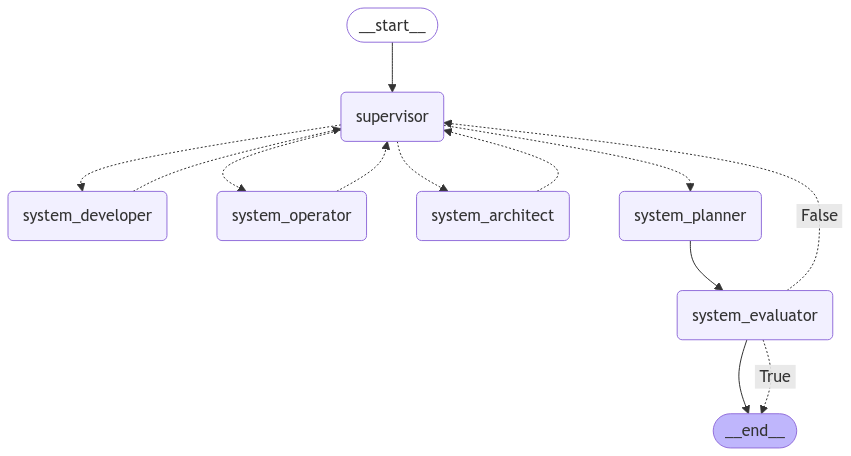

In [31]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

### 処理実行

In [32]:
try:
    state = State(query="電卓のアプリを作成")
    print(f"State object: {state}")
    for s in graph.stream(state):
        print(s)
        print("--------------------------------------")
except Exception as e:
    print(f"An error occurred: {e}")

State object: query='電卓のアプリを作成' messages=[] current_judge=False judgement_reason=''
Next Member: system_developer
{'supervisor': None}
--------------------------------------
{'system_developer': {'messages': ['system_developer', '### システム開発プロジェクトの要件と確認ポイント\n\n#### 1. プロジェクトの目的と範囲  \n- **目的**: ユーザーが簡単に数値計算を行える電卓アプリを開発する。  \n- **範囲**: 基本的な加算、減算、乗算、除算機能を提供し、履歴機能やテーマ変更機能などを追加する可能性がある。\n\n#### 2. 主要な技術的課題とその解決策  \n- **課題**: 直感的なユーザーインターフェースの設計  \n  **解決策**: ユーザーエクスペリエンス(UX)デザインの専門家と協力して、プロトタイプを作成し、ユーザーテストを行う。  \n- **課題**: 各種デバイスへの対応  \n  **解決策**: モバイルファーストのアプローチを採用し、レスポンシブデザインを実施する。\n\n#### 3. 必要なリソースとスキルセット  \n- **リソース**:  \n  - 開発者（フロントエンド、バックエンド）  \n  - デザイナー（UX/UI）  \n  - QAエンジニア（テスト担当）  \n- **スキルセット**:  \n  - プログラミング言語（JavaScript, Python, Swiftなど）  \n  - フレームワーク（React, Angular, Vue.jsなど）  \n  - デザインツール（Figma, Adobe XDなど）  \n  - テストプロセスの知識（ユニットテスト、統合テスト）\n\n#### 4. 開発プロセスの各フェーズでの重要なマイルストーン  \n- **要件定義**: ユーザー要求の収集と文書化  \n- **デザインフェーズ**: プロトタイプの作成とユーザーテスト  \n- **開発フェーズ**: コードの実装と機能の統合  \

In [33]:
try:
    state = State(query="スマートフォンを用いた電子決済システム")
    print(f"State object: {state}")
    for s in graph.stream(state):
        print(s)
        print("--------------------------------------")
except Exception as e:
    print(f"An error occurred: {e}")

State object: query='スマートフォンを用いた電子決済システム' messages=[] current_judge=False judgement_reason=''
Next Member: system_developer
{'supervisor': None}
--------------------------------------
{'system_developer': {'messages': ['system_developer', '### スマートフォンを用いた電子決済システムのシステム開発要件\n\n#### 1. プロジェクトの目的と範囲\n- **目的**: ユーザーが簡単かつ安全にスマートフォンを使用して電子決済を行えるシステムの構築。\n- **範囲**: 主要機能として、ユーザー登録、決済処理、履歴管理、セキュリティ機能（生体認証、暗号化）、およびサポート機能（FAQ、カスタマーサポート）を含む。\n\n#### 2. 主要な技術的課題とその解決策\n- **課題**: 取引のセキュリティ確保、ユーザー体験の向上、異なる決済方法の統合。\n  - **解決策**:  \n    - 強力な暗号化技術（AES、RSAなど）を使用し、トランザクションを安全に処理。\n    - ユーザーインターフェース（UI）のテストを重ねて、直感的で使いやすいデザインを実現。\n    - APIを通じて複数の決済方法（クレジットカード、QRコード、ウォレット）を統合する。\n\n#### 3. 必要なリソースとスキルセット\n- **リソース**:\n  - 開発者（フロントエンド、バックエンド、モバイルアプリ開発）\n  - UI/UXデザイナー\n  - テストエンジニア\n  - システム管理者 / DevOps\n- **スキルセット**:\n  - プログラミング言語（Java、Swift、JavaScriptなど）\n  - データベース管理（MySQL、MongoDBなど）\n  - セキュリティ対策の知識\n  - API設計と統合の経験\n\n#### 4. 開発プロセスの各フェーズでの重要なマイルストーン\n- **要件定義**: ユーザー要件と技術要件の明確化。\n- **設計**: システムアーキテクチ